# Выбор оптимальной гипотезы для увеличения выручки интернет магазина и проверка её с помощью A/B-теста.

## Открытие файлов с данными, изучение информации, коррекция данных

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import scipy.stats as stats
import datetime as dt
import math as mth
from pandas.plotting import register_matplotlib_converters
import warnings

In [24]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [25]:
hypothesis.info()
hypothesis.head(9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В таблице hypothesis типы данных корректные, дубликаты отсутствуют.

In [26]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [27]:
orders.duplicated().sum()

0

Дубликатов нет, исправим тип данных в столбце date на datatime

In [28]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [29]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [30]:
visitors.duplicated().sum()

0

Дубликатов нет, исправим тип данных в столбце date на datatime

In [31]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Недостатки устранены, данные готовы к анализу

In [32]:
# за какой период нам доступны данные (даты начала и окончания теста)
orders['date'].describe()

C:\Users\User01\AppData\Local\Temp\ipykernel_8504\2251232272.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders['date'].describe()


count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Данные представлены за месяц август с 2019-08-01 по 2019-08-31

In [33]:
# Подтвердить количество групп в А/Б тесте
# Посмотреть на распределение количества пользователей в каждой группе
orders.groupby('group').count()

,transactionId,visitorId,date,revenue
group,,,,
A,557,557,557,557
B,640,640,640,640


In [34]:
len(np.intersect1d(orders.query('group == "A"')['visitorId'], orders.query('group == "B"')['visitorId'], assume_unique = False))


58

Да, количество групп две, лишних групп нет. Группа В больше на 83 человека. Группы должны не должны так различаться по количеству. Проверим не попадают ли у нас пользователи в обе группы.

In [35]:
order_1 = orders.loc[orders["group"]=="B", "visitorId"].isin(orders.loc[orders["group"]=="A", "visitorId"])
order = orders.drop(order_1[order_1].index)
order

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Да, у нас были одинаковые пользователи в группах. Так как в группе В пользователей больше чем А, удалим одинаковых пользователей из группы В

# Часть 1. Приоритизация гипотез.

**Применение фреймворка ICE для приоритизации гипотез**

ICE Scoring — это метод определения приоритетов

В ICE вы оцениваете идеи таким образом:
- Impact. Влияние демонстрирует, насколько идея положительно повлияет на ключевой показатель, который вы пытаетесь улучшить.
- Efforts. Легкость реализации или простота — это оценка того, сколько усилий и ресурсов требуется для реализации этой идеи.
- Confidence. Уверенность демонстрирует, насколько вы уверены в оценках влияния и легкости реализации.

In [36]:
pd.options.display.max_colwidth = 210
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) 
                     / hypothesis['Efforts']).round()
hypothesis[['ICE', 'Hypothesis']].sort_values(by='ICE', ascending=False)

,ICE,Hypothesis
8,16.0,"Запустить акцию, дающую скидку на товар в день рождения"
0,13.0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
7,11.0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
6,8.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
2,7.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
1,2.0,"Запустить собственную службу доставки, что сократит срок доставки заказов"
3,1.0,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
4,1.0,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"
5,1.0,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"


Наиболее перспективные гипотезы по ICE: гипотезы с индексами - 8, 0, 7.

**Применение фреймворка RICE для приоритизации гипотез**

Фреймворк RICE состоит из четырёх компонентов:
- Reach — скольких пользователей затронет изменение, которое вы хотите внести
- Impact, Confidence, Efforts;

In [37]:
pd.options.display.max_colwidth = 210
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis[['Reach','RICE', 'Hypothesis']].sort_values(by='RICE', ascending=False)

,Reach,RICE,Hypothesis
7,10,112.0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
2,8,56.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
0,3,40.0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
6,5,40.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
8,1,16.2,"Запустить акцию, дающую скидку на товар в день рождения"
3,8,9.0,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
1,2,4.0,"Запустить собственную службу доставки, что сократит срок доставки заказов"
5,3,4.0,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
4,3,3.0,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


Наиболее перспективные гипотезы по RICE: гипотезы с индексами - 7, 2, 0.

Приоритизация гипотез изменилась  при применении RICE вместо ICE, потому что в  RICE мы учитываем важный параметр - Reach (скольких пользователей затронет изменение, которое мы хотим внести). 

In [38]:
#Пронумеруем гипотезы по порядку
hypothesis['numbers']= np.arange(len(hypothesis))+1

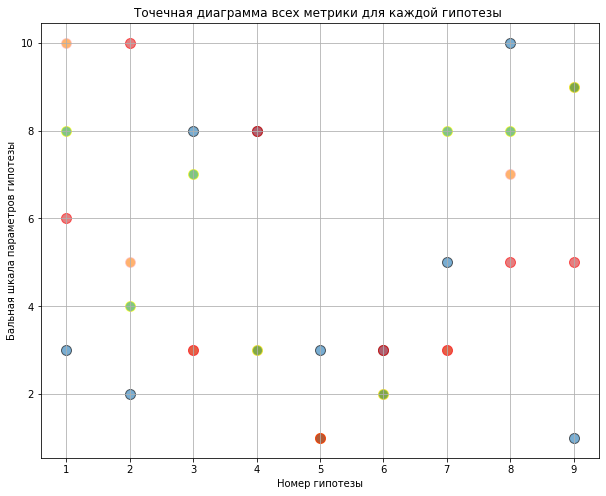

In [39]:
# Точечная диаграмма, чтобы сопоставить все метрики для каждой гипотезы и сравнить их
Hypothesi = hypothesis['numbers']
Reach = hypothesis['Reach']
Impact = hypothesis['Impact']
Confidence = hypothesis['Confidence']
Efforts = hypothesis['Efforts']
plt.figure(figsize=(10,8))
plt.scatter(Hypothesi,  Reach, s=100, alpha=0.6, edgecolor='black', linewidth=1)
plt.scatter(Hypothesi, Impact, s=100, alpha=0.6, edgecolor='pink', linewidth=1)
plt.scatter(Hypothesi, Confidence, s=100, alpha=0.6, edgecolor='yellow', linewidth=1)
plt.scatter(Hypothesi, Efforts, s=100, alpha=0.6, edgecolor='red', linewidth=1)
plt.title('Точечная диаграмма всех метрики для каждой гипотезы ')
plt.xlabel('Номер гипотезы')
plt.ylabel('Бальная шкала параметров гипотезы')
plt.grid()

plt.show()

На графике видно, как гипотеза № 8 доминирует по показателям. Все её показатели находятся выше 5 балов 

Выводы:
- лидирующие строчки в таблицах разные. В ICE это гипотезы под номерами 9,1, 8, а в RICE 8,3,1. 
- в № 8 гипотезе это 10 человек, что является максимумом. В гипотезе № 9 всего 1 человек, хотя занимает 1 строчку при расчете ICE
- рекомендуем протестировать гипотезу № 8 


# Часть 2. Анализ A/B-теста

##  График кумулятивной выручки по группам. 

In [40]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'transactionId' : 'nunique', 
            'visitorId' : 'nunique', 
            'revenue' : 'sum'
        }
    ), 
    axis=1
).sort_values(by=['date','group'])


# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'visitors' : 'sum'
        }
    ), 
    axis=1
).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


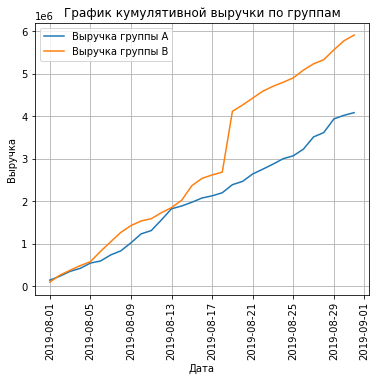

In [43]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим графики выручки группы А и В
plt.figure(figsize=(6,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Выручка группы A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Выручка группы B')
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=90)
plt.grid()
plt.legend() ;

Выводы и предположения:
- До 13 августа выручка в группе В растет быстрее, чем А.
- 13 августа они равны
- Во второй половине месяца группа значительно превышает выручку.
- Всплеск роста - 19 августа.
- Предполагаем - связанно с наличием больших заказов, в этот день.
- Если рассмотреть график без всплеска больших заказов, то выручка росла практически одинаково (графики параллельны)

**Рассмотрим какие заказы были в районе 19 августа**

In [44]:
cumulativeRevenueB.query(' "2019-08-16" <= date <= "2019-08-21" ')

,date,revenue,orders
31,2019-08-16,2539635,359
33,2019-08-17,2620790,373
35,2019-08-18,2686621,382
37,2019-08-19,4116541,403
39,2019-08-20,4263815,423
41,2019-08-21,4426892,437


In [45]:
#Сколь в среднем тратят на заказ 19  августа 
median_19 = orders.query('date == "2019-08-19"')['revenue'].median()
print('Медианное значение заказа на 19 августа =', median_19)
orders.query('date == "2019-08-19" & group =="B"').sort_values(by='revenue', ascending=False).head()

Медианное значение заказа на 19 августа = 2630.0


,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
527,1570513684,2837914161,2019-08-19,33405,B
461,2683113224,154576532,2019-08-19,26550,B
368,3268879337,2536252163,2019-08-19,20026,B
463,4170537404,290022471,2019-08-19,16480,B


Был заказ  №425, 19 августа  который почти в 500 раз больше медианы.
Этот заказ один,  можно считать выбросом и при дальнейшем анализе это надо учитывать.

## График кумулятивного среднего чека по группам

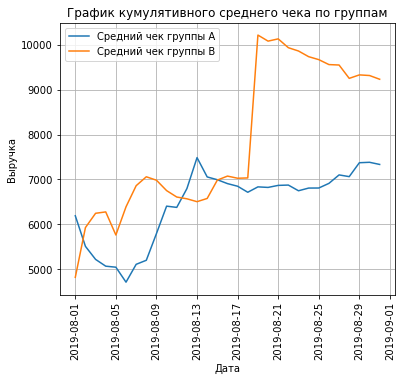

In [47]:
# Строим графики среднего чека группы А и В
plt.figure(figsize=(6,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Средний чек группы A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Средний чек группы B')
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation=90)
plt.grid()
plt.legend() ;

Выводы:
- В первой половине в группе B чек преимущественно больше, но есть даты где и наоборот 
- Чек больше в A -  1 августа и 12-14 августа. 
- В основном B стабильно больше. 
- Видно сильное влияние на средний чек заказа №425
- После 19 августа средний чек в B плавно снижается
- Но в группе A он с 18 августа медленно нарастает.

## График относительного изменения кумулятивного среднего чека группы B к группе A

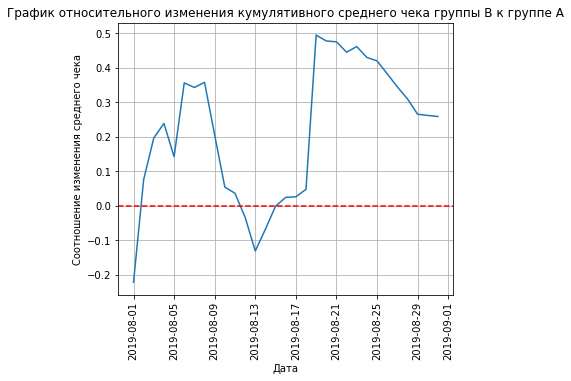

In [48]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(6,5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
             mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Соотношение изменения среднего чека")
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=90)
plt.grid() ;

Выводы:
- На графике видны несколько резких скачков. Это крупные заказы и выбросы 
- Средний чек B растёт и 2 августа уже превышает A и останавливает рост 7 августа
- После 7 августа наблюдается падение до 13 августа
- С 12 по 15 августа средний чек A был больше B
- С 16 августа чек находится больше A до конца месяца. 
- Хорошо видно, что 19 августа был сильный всплеск (рост) за счет заказа №425 с аномально большим объемом

## График кумулятивного среднего количества заказов по группам. 

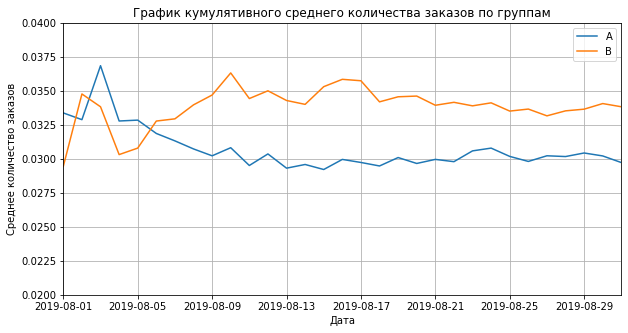

In [49]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
#Строим график 
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xlabel("Дата")
plt.ylabel("Среднее количество заказов")
plt.title('График кумулятивного среднего количества заказов по группам')
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.02, 0.04]);

Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

Выводы:
- С начала месяца среднего количества заказов до 5 августа группы A была больше
- После пика начинается падение и начиная с 9 августа переходит в стагнацию в минимальном диапазоне 0,0295-0,031
-  Среднее количество заказов группы B с 4 августа начинает рост, 6 августа превышает показатель A и росла до 10 августа не превышая 0,0365
- Далее в группе В постепенное снижение, но с небольшой динамикой между 15 и 17 числом  

## График относительного изменения кумулятивного среднего количества заказов группы B к группе A.

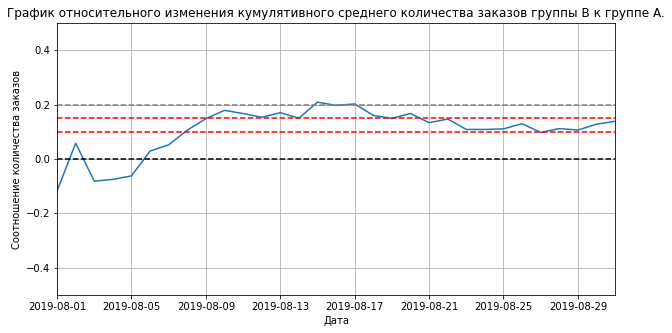

In [50]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']],\
    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xlabel("Дата")
plt.ylabel("Cоотношение количества заказов")
plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A.')

plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.15, color='red', linestyle='--') 
plt.axhline(y=0.1, color='red', linestyle='--') 
plt.axhline(y=0.2, color='grey', linestyle='--')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.5, 0.5]);

Начиная с 6 числа группа B лидирует по кумулятивному среднему количеству заказов: растет, зафесировалость на приросте в 20% и спустилось до 10 %

Выводы:
- С 3 по 5 - несколько дней, когда конверсия в A была больше на 5-10%; 
- 2 августа - был сильный рост конверсии в группе B и по итогу дня результат "B" был на 5% больше "A" 
- Предположим по графику из пункта 4 (где заметен скачок кумулятивного среднего количества заказов), что была акция или скидка
- Начиная с 6 августа группа В  лидировала до конца периода; 
- Кумулятивное среднее количество заказов росло до 15 августа, и разница с A на максимуме составила около 20%, затем плавное снижение показателя до 10%-14%.

## Точечный график количества заказов по пользователям. 

In [51]:
#Подсчитаем количество заказов по пользователям 
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head())

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


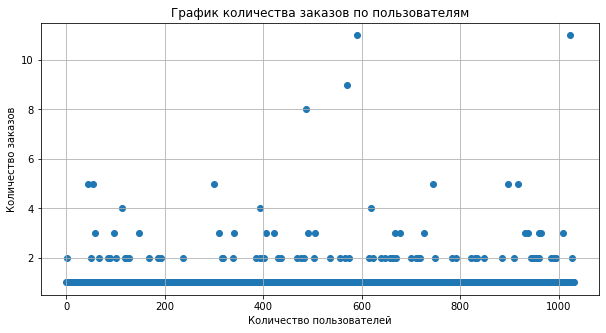

In [52]:
x_values = pd.Series(range(0,len(ordersByUsers)))


plt.figure(figsize=(10,5))
plt.grid()
plt.xlabel("Количество пользователей")
plt.ylabel("Количество заказов")
plt.title('График количества заказов по пользователям')

plt.scatter(x_values, ordersByUsers['orders']);

Выводы:
- Больше всего пользователей которые совершили 1 заказ. 
- Много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет 
- Нужно посчитать процентили (95 и 99)

## Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.

In [53]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


In [54]:
# Для большей точности рассчитаем все процентили с 95 по 99
print(np.percentile(ordersByUsers['orders'], [95,96,97,98, 99]))

[2. 2. 2. 3. 4.]


Не более 2% пользователей оформляли больше чем 3 заказа и не более 3 % пользоавтелей совершали 2 заказов.
Разумно выбрать 2 или 3 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

## Постройть точечный график стоимостей заказов. 

In [55]:
# 19 числа был очень большой заказ и по крафикам видно, что есть ещё большие заказы.
# Чтобы определится с числом по которому мы органичим выборку, отсортируем данные
orders_head = orders['revenue'].sort_values(ascending=False).head()
orders_head

425     1294500
1196     202740
858       93940
1136      92550
744       86620
Name: revenue, dtype: int64

Есть заказ на сумму 202740. Это будет нашим потолком цен

In [56]:
orders_1 = orders[orders['revenue']< 202740]
orders_1

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


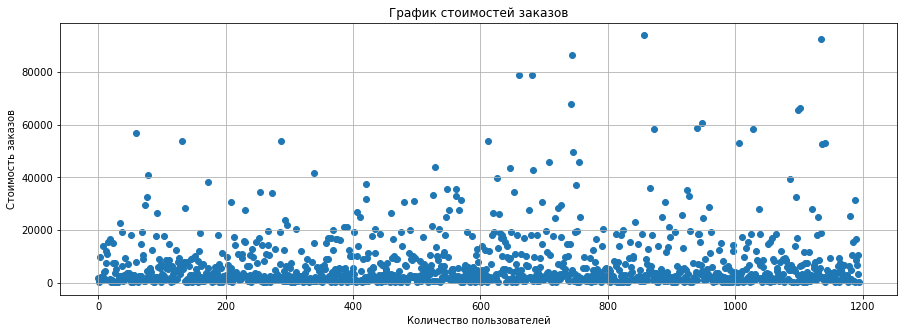

In [59]:
# В данных есть выбросы, которые искажают график. Уберем значения больше 202740 .
orders_1 = orders[orders['revenue']< 202740]['revenue']
xn_values = pd.Series(range(0,len(orders_1)))
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Количество пользователей")
plt.ylabel("Стоимость заказов")
plt.title('График стоимостей заказов')
plt.scatter(xn_values, orders_1);


Выводы и предположения:
- Средняя стоимость заказа не превышает 20000 тыс.руб. 
- Чтобы найти более точную границу аномальных заказов рассчитаем процентили.

## Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

In [60]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


5% заказов не более 28000. Только 1 % не превышает суммы 58233.2 , установим её в качестве границы для аномалий.

## Посчитать статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным.

In [61]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1
)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1
)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [62]:
# Полученные данные соеденим в одну таблицу
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Описание данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

 Метод, который будем применять для A/B-тестирования, называется st.mannwhitneyu(). К ниму прибегают тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты. Выбросы у нас присутсвуют , поэтому вариант подходит

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 
Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой (пороговое значение возьмём равное 5%).

За нулевую гипотезу возьмём что: статистически значимых различий в среднем количестве заказов между группами нет; Альтернативная гипотеза: статистически значимые различия есть.

In [63]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

p_value =stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]
alpha = 0.05
print("alpha =", alpha)
print("p-value =" , p_value)
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 



alpha = 0.05
p-value = 0.016792355056752608
Относительный показатель 'B' и 'A' = 0.138


In [64]:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

Отвергаем нулевую гипотезу: разница статистически значима


Вывод:
p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Это значит: по «сырым» данным различия в конверсии групп A и B есть. Однако относительный выигрыш группы "B" над "A" равен 13.8% .

## Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Чтобы рассчитать статистическую значимость различий в среднем чеке между группами, передадим критерию mannwhitneyu() данные о выручке с заказов (пороговое значение возьмём равное 5%). И найдём относительные различия в среднем чеке между группами.

Нулевая гипотеза : статистически значимых различий в средних чеках между группами нет; 

Альтернативная гипотеза: статистически значимые различия есть.

In [65]:
p_value = stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'],orders[orders['group']=='B']['revenue'], alternative = 'two-sided'
)[1]
alpha = 0.05

print("alpha =", alpha)
print("p-value = {0:.3f}".format(p_value))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()
                                                            /orders[orders['group']=='A']['revenue'].mean()-1)) 

alpha = 0.05
p-value = 0.729
Относительный показатель 'B' и 'A' = 0.259


In [66]:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

Не получилось отвергнуть нулевую гипотезу


Выводы и предположения:
- P-value значительно больше 0.05. 
- Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
- Средние чеки по "сырым" данным схожи. Впрочем, средний чек группы B значительно выше среднего чека группы A.

## Посчитать статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным.

- Из предыдущих пунктов были приняты за аномальных пользователей тех, кто совершил 3 и больше заказов или совершил заказ дороже 58233.2 рублей. 
- Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 58233.2 — usersWithExpensiveOrders. 
- Объединим их в таблице abnormalUsers. Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [67]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233.2]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head())
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64
31


Повлияли ли их действия на результаты теста? Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [68]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

- Применим статистический критерий Манна-Уитни к полученным выборкам
- Ho: "статистически значимых различий в конверсии между группами нет"; 
- Альтернативная гипотеза будет гласить - статистически значимые различия есть.

In [69]:
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]
alpha = 0.05
print("alpha =", alpha)
print("p-value = {0:.3f}".format(p_value))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.010
Относительный показатель 'B' и 'A' = 0.174


In [70]:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу: разница статистически значима


Вывод: 
- p-value = 0.01 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий между группами нет, - отвергаем.
- По «очищенным» данным различия групп A и B есть. А относительный выигрыш группы "B" над "A" равен 17,4% (выше, чем с «сырыми» данными - 13.8%) .

## Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

А теперь мосмотрим произошло ли что-нибудь с результатами по среднему чеку?

За нулевую гипотезу возьмём что: "статистически значимых различий в средних чеках между группами нет"; тогда альтернативная гипотеза будет гласить - статистически значимые различия есть.

In [71]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)
print(
    "Относительный показатель 'B' и 'A' ={0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.798
Относительный показатель 'B' и 'A' =-0.020


Выводы:
- P-value больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия,тоже нет ,как и с "сырыми" данными. 
- А вот средний чек группы B оказался на 2% ниже среднего чека группы A, в то время как по "сырым" данным, он больше на 26%
- Это связанно с аномальным заказом №425 на 1,3 млн
- Такой пример хорошо показывает, как сильно аномалии могут влиять на результаты A/B-теста!

## Решения по результатам теста 

Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Имеющиеся факты:
- Есть статистические значимые различия по среднему количеству заказов между группами по «сырым» и по данным после фильтрации аномалий. Относительный выигрыш группы "B" над "A" равен 17,4% по "очищенным" и 13.8% по "сырым" данным;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.Несмотря на то, что средний чек группы B оказался на 2% ниже среднего чека группы A по "очищенным" данным, а по "сырым" данным, он был большьше 26%. Это все из-за заказа на 1,3 млн.

Решение по результатам теста.
- Исходя из обнаруженных фактов, тест следует остановить и констатировать успех и победу группы B. 
- Группа B значительно эффективнее группы A по среднему количества заказов по группам, хотя по среднему чеку группы примерно равны.